## Konsumer Kafki dla Zadania Zaliczeniowego 2


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StringType, FloatType, IntegerType

PYSPARK_SCALA_VERSION="2.12"
SPARK_VERSION="3.5.6"
KAFKA_VERSION="3.9.0"

packages = [
    f'org.apache.spark:spark-sql-kafka-0-10_{PYSPARK_SCALA_VERSION}:{SPARK_VERSION}',
    f'org.apache.kafka:kafka-clients:{KAFKA_VERSION}'
]

spark = SparkSession.builder \
                    .master("spark://master:7077") \
                    .config("spark.jars.packages", ",".join(packages)) \
                    .appName("mlibs") \
                    .getOrCreate()


:: loading settings :: url = jar:file:/home/pa_wojciesza/venv/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/pa_wojciesza/.ivy2/cache
The jars for the packages stored in: /home/pa_wojciesza/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.kafka#kafka-clients added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a9757e71-fc16-4b58-8107-4d26834e4a9a;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.6 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.6 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found com.github.luben#zstd-jni;1.5.6

In [ ]:
from pyspark.sql.functions import from_json, col, lit, to_timestamp, window
from pyspark.sql.types import StructType, StringType, IntegerType, FloatType

schema = StructType() \
    .add("timestamp", StringType()) \
    .add("PULocationID", IntegerType()) \
    .add("DOLocationID", IntegerType())

def parse_df(df_raw, topic_name):
    df_json = df_raw.selectExpr("CAST(value AS STRING) as json_str")
    return df_json \
        .withColumn("data", from_json(col("json_str"), schema)) \
        .select("data.*") \
        .withColumn("from_topic", lit(topic_name)) \
        .withColumn("timestamp_parsed", to_timestamp(col("timestamp"))) \
        .drop("timestamp")

# Odczyt z topicu 'start_topic'
df_raw_start = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", "start_topic") \
    .option("startingOffsets", "earliest") \
    .load()

# Odczyt z topicu 'end_topic'
df_raw_end = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", "end_topic") \
    .option("startingOffsets", "earliest") \
    .load()

df_start = parse_df(df_raw_start, "start_topic")
df_end = parse_df(df_raw_end, "end_topic")
df_combined = df_start.union(df_end)

# query = df_combined.writeStream \
#     .outputMode("append") \
#     .format("console") \
#     .option("truncate", False) \
#     .start()

# try:
#     query.awaitTermination()
# except KeyboardInterrupt:
#     print("Stopping the streaming query due to manual interrupt.")
#     query.stop()

In [ ]:
!/opt/hadoop/bin/hdfs dfs -put taxi1/253 /taxi1/253

In [ ]:
!tar -xvzf taxi.tar.gz

In [ ]:
!/opt/hadoop/bin/hdfs dfs -ls /

In [ ]:
!/opt/hadoop/bin/hdfs dfs -rm -r -f /taxi1/2412
!/opt/hadoop/bin/hdfs dfs -rm -r -f /checkpoint2412

df_windowed = df_combined \
    .withWatermark("timestamp_parsed", "1 day") \
    .groupBy(
        window(col("timestamp_parsed"), "1 hour"),
        col("PULocationID"),
        col("DOLocationID")
    ).count()

def show_batch(df, batch_id):
    print(f"=== BATCH {batch_id} ===")
    df.show(truncate=False)

query = df_windowed.writeStream \
    .outputMode("append") \
    .foreachBatch(show_batch) \
    .option("checkpointLocation", "hdfs://master:9000/checkpoint2412") \
    .start()

# # Zapis do Parquet
# query = df_windowed.writeStream \
#     .outputMode("append") \
#     .format("parquet") \
#     .option("path", "hdfs://master:9000/taxi1/253") \
#     .option("checkpointLocation", "hdfs://master:9000/checkpoint253") \
#     .start()

try:
    query.awaitTermination()
except KeyboardInterrupt:
    print("Stopping the streaming query due to manual interrupt.")
    query.stop()

 Show that you can do SQL queries on the stream. Compute the total number of trips (of any kind finished or ongoing) between all pairs of zones for each wall clock hour. You can create intermediate streams if you need.

# Zrzut ekranu dokumentujący działanie (z parametrem outputMode("update"))

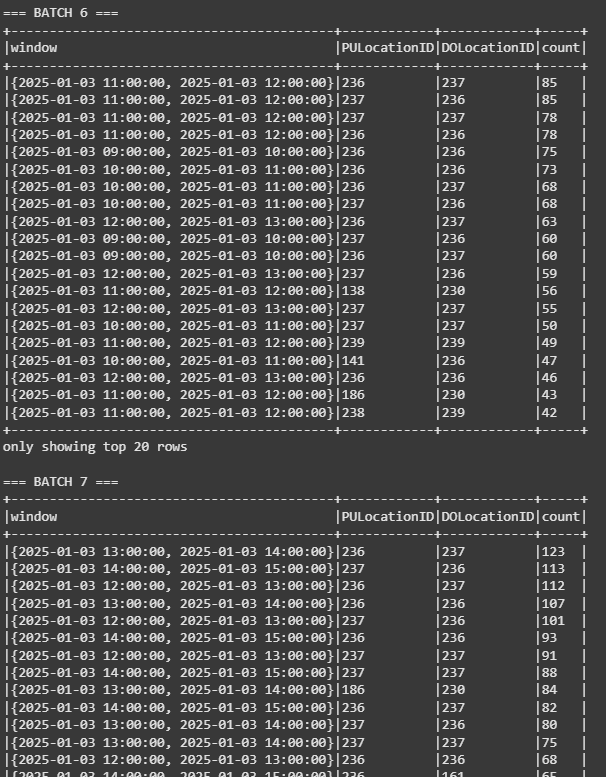

Use the computed statistics to discover days with unusual traffic (do it separately for different days of the week).

In [ ]:
df_taxi_251 = spark.read.parquet("hdfs://master:9000/taxi1/251")
df_taxi_252 = spark.read.parquet("hdfs://master:9000/taxi1/252")
df_taxi_2 = spark.read.parquet("hdfs://master:9000/taxi")
df_taxi_hour = df_taxi_252.union(df_taxi_2)
# df_taxi_hour.printSchema()

In [ ]:
df_taxi_hour.show(5)

+--------------------+------------+------------+-----+
|              window|PULocationID|DOLocationID|count|
+--------------------+------------+------------+-----+
|{2024-12-08 20:00...|         186|         249|    8|
|{2024-12-09 09:00...|          79|         148|    2|
|{2024-12-08 20:00...|         138|          61|    2|
|{2024-12-09 05:00...|         132|         228|    1|
|{2024-12-09 06:00...|          41|          74|    2|
+--------------------+------------+------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import to_date, col, abs, sum as spark_sum, avg, stddev, dayofweek, when

df_daily = df_taxi_hour.withColumn("date", to_date("window.start")) \
    .groupBy("date") \
    .agg(spark_sum("count").alias("total_rides"))

df_daily = df_daily.withColumn("weekday", dayofweek("date"))

weekday_stats = df_daily.groupBy("weekday").agg(
    avg("total_rides").alias("avg_rides"),
    stddev("total_rides").alias("std_rides")
)

weekday_stats = weekday_stats.withColumn(
    "std_rides",
    when(col("std_rides").isNull() | (col("std_rides") == 0), 1).otherwise(col("std_rides"))
)

df_with_stats = df_daily.join(weekday_stats, on="weekday")

In [ ]:
df_with_zscore = df_with_stats.withColumn(
    "z_score",
    ((col("total_rides") - col("avg_rides")) / col("std_rides"))
)

df_outliers = df_with_zscore.filter(abs(col("z_score")) > 1)

In [ ]:
df_outliers.select("date", "weekday", "total_rides", "z_score").orderBy("date").show(10)

+----------+-------+-----------+-------------------+
|      date|weekday|total_rides|            z_score|
+----------+-------+-----------+-------------------+
|2024-11-30|      7|         33|-1.4364732899361061|
|2024-12-02|      2|     211462| 1.5646062360006638|
|2024-12-05|      5|     273258| 1.6898053899312582|
|2024-12-10|      3|         51|-1.9956245687279763|
|2024-12-11|      4|          2| -2.004064486621233|
|2024-12-28|      7|          4|-1.4367382783160891|
|2025-01-31|      6|         41|-1.7451125265424816|
|2025-02-17|      2|     151447|-1.2481418120541694|
|2025-03-02|      1|          2|-2.1647238758390928|
+----------+-------+-----------+-------------------+



In [ ]:
df_daily.select("date").distinct().orderBy("date").show(100)

+----------+
|      date|
+----------+
|2024-11-30|
|2024-12-01|
|2024-12-02|
|2024-12-03|
|2024-12-04|
|2024-12-05|
|2024-12-06|
|2024-12-07|
|2024-12-08|
|2024-12-09|
|2024-12-10|
|2024-12-11|
|2024-12-28|
|2025-01-31|
|2025-02-01|
|2025-02-02|
|2025-02-03|
|2025-02-04|
|2025-02-05|
|2025-02-06|
|2025-02-07|
|2025-02-08|
|2025-02-09|
|2025-02-10|
|2025-02-11|
|2025-02-12|
|2025-02-13|
|2025-02-14|
|2025-02-15|
|2025-02-16|
|2025-02-17|
|2025-02-18|
|2025-02-19|
|2025-02-20|
|2025-02-21|
|2025-02-22|
|2025-02-23|
|2025-02-24|
|2025-02-25|
|2025-02-26|
|2025-02-27|
|2025-03-02|
+----------+



<center>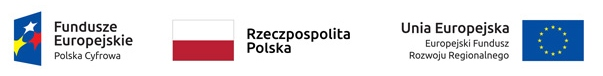</center>